# Most IMP ones

1ST CODE XGBoost & LightGBM, CatBoost 72%avg

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:55:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ ADHD_Outcome Accuracy: 0.8065843621399177

📊 Classification Report for ADHD_Outcome:
              precision    recall  f1-score   support

           0       0.78      0.55      0.64        77
           1       0.81      0.93      0.87       166

    accuracy                           0.81       243
   macro avg       0.80      0.74      0.75       243
weighted avg       0.80      0.81      0.80       243



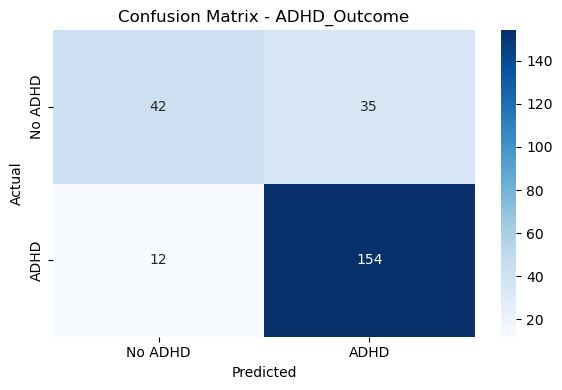

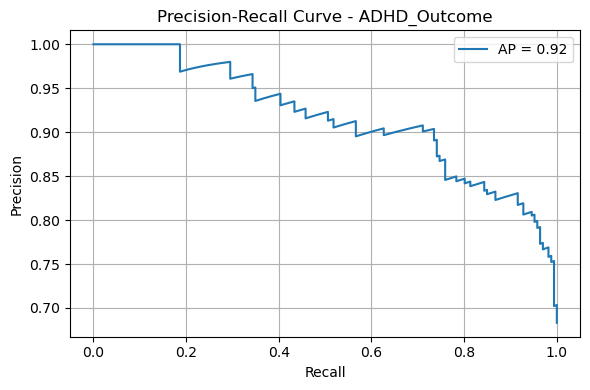

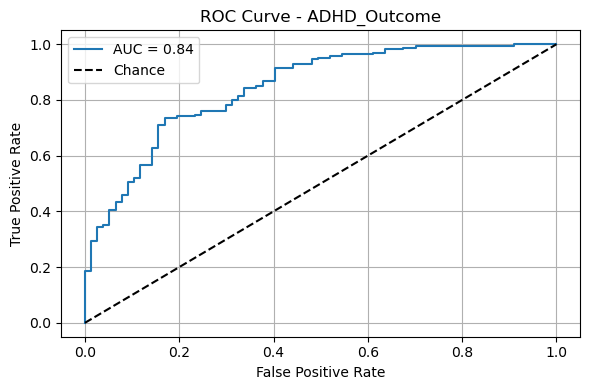

[LightGBM] [Info] Number of positive: 637, number of negative: 637
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106287
[LightGBM] [Info] Number of data points in the train set: 1274, number of used features: 428
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

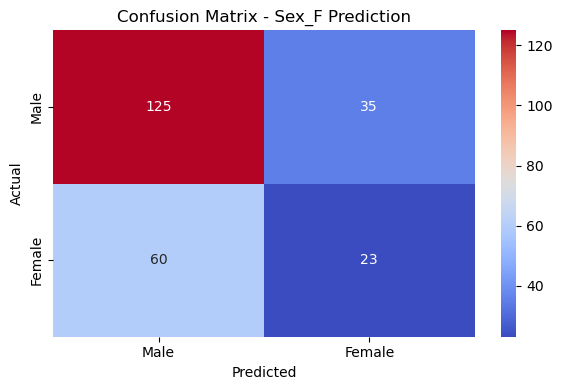

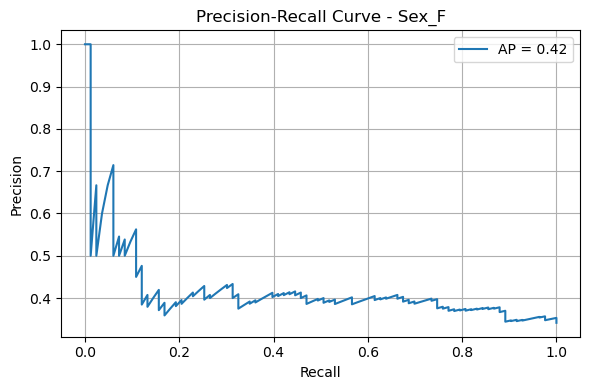

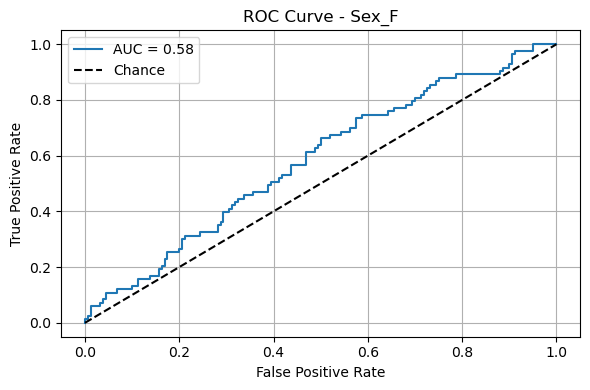

In [ ]:
#77
# === 0. Import all libraries ===
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# === 1. Load training data ===
data = np.load(r"final_preprocessed_for_modeling100.npy", allow_pickle=True).item()
functional_matrix = data['functional_matrix_pca']
metadata = pd.DataFrame(data['metadata'])

# === 2. Extract target columns ===
y_adhd = metadata['ADHD_Outcome'].astype(int).values
y_sex = metadata['Sex_F'].astype(int).values
X_meta = metadata.drop(columns=['ADHD_Outcome', 'Sex_F'], errors='ignore')

# === 3. One-hot encode metadata ===
X_meta_encoded = pd.get_dummies(X_meta)
X_combined = np.hstack((functional_matrix, X_meta_encoded.values))

# === 4. ADHD_Outcome Model (XGBoost) ===
X_train_adhd, X_test_adhd, y_train_adhd, y_test_adhd = train_test_split(
    X_combined, y_adhd, test_size=0.2, random_state=42, stratify=y_adhd
)

scaler_adhd = StandardScaler()
X_train_adhd_scaled = scaler_adhd.fit_transform(X_train_adhd)
X_test_adhd_scaled = scaler_adhd.transform(X_test_adhd)

xgb_model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_adhd_scaled, y_train_adhd)

y_pred_adhd = xgb_model.predict(X_test_adhd_scaled)

print("\n✅ ADHD_Outcome Accuracy:", accuracy_score(y_test_adhd, y_pred_adhd))
print("\n📊 Classification Report for ADHD_Outcome:")
print(classification_report(y_test_adhd, y_pred_adhd))

# === ADHD Confusion Matrix ===
cm_adhd = confusion_matrix(y_test_adhd, y_pred_adhd)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adhd, annot=True, fmt='d', cmap='Blues', xticklabels=["No ADHD", "ADHD"], yticklabels=["No ADHD", "ADHD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ADHD_Outcome")
plt.tight_layout()
plt.show()

# === ADHD Precision-Recall Curve ===
y_scores_adhd = xgb_model.predict_proba(X_test_adhd_scaled)[:, 1]
precision_adhd, recall_adhd, _ = precision_recall_curve(y_test_adhd, y_scores_adhd)
ap_adhd = average_precision_score(y_test_adhd, y_scores_adhd)

plt.figure(figsize=(6, 4))
plt.plot(recall_adhd, precision_adhd, label=f'AP = {ap_adhd:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - ADHD_Outcome')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

from sklearn.metrics import roc_curve, roc_auc_score

# === ADHD ROC Curve ===
fpr_adhd, tpr_adhd, _ = roc_curve(y_test_adhd, y_scores_adhd)
roc_auc_adhd = roc_auc_score(y_test_adhd, y_scores_adhd)

plt.figure(figsize=(6, 4))
plt.plot(fpr_adhd, tpr_adhd, label=f"AUC = {roc_auc_adhd:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ADHD_Outcome")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === 5. Sex_F model (LGBM + CatBoost Ensemble) ===
X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(
    X_combined, y_sex, test_size=0.2, random_state=42, stratify=y_sex
)

# SMOTE
smote = SMOTE(random_state=42)
X_train_sex_resampled, y_train_sex_resampled = smote.fit_resample(X_train_sex, y_train_sex)

scaler_sex = StandardScaler()
X_train_sex_scaled = scaler_sex.fit_transform(X_train_sex_resampled)
X_test_sex_scaled = scaler_sex.transform(X_test_sex)

# LightGBM model
lgbm_model = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.03,
    max_depth=7,
    class_weight='balanced',
    random_state=42
)
lgbm_model.fit(X_train_sex_scaled, y_train_sex_resampled)

# CatBoost model
classes = np.unique(y_train_sex_resampled)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_sex_resampled)
class_weights_dict = dict(zip(classes, weights))

catboost_model = CatBoostClassifier(
    iterations=400,
    learning_rate=0.03,
    depth=8,
    random_state=42,
    verbose=0,
    class_weights=class_weights_dict
)
catboost_model.fit(X_train_sex_scaled, y_train_sex_resampled)

# Predict Sex_F (Ensemble)
lgbm_preds = lgbm_model.predict(X_test_sex_scaled)
catboost_preds = catboost_model.predict(X_test_sex_scaled)
sex_preds_final = np.where((lgbm_preds + catboost_preds) >= 1, 1, 0)

print("\n✅ Sex_F Accuracy:", accuracy_score(y_test_sex, sex_preds_final))
print("\n📊 Classification Report for Sex_F:")
print(classification_report(y_test_sex, sex_preds_final))

# === Sex Confusion Matrix ===
cm_sex = confusion_matrix(y_test_sex, sex_preds_final)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_sex, annot=True, fmt='d', cmap='coolwarm', xticklabels=["Male", "Female"], yticklabels=["Male", "Female"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Sex_F Prediction")
plt.tight_layout()
plt.show()

# === Sex Precision-Recall Curve ===
lgbm_probs = lgbm_model.predict_proba(X_test_sex_scaled)[:, 1]
catboost_probs = catboost_model.predict_proba(X_test_sex_scaled)[:, 1]
avg_probs_sex = (lgbm_probs + catboost_probs) / 2

precision_sex, recall_sex, _ = precision_recall_curve(y_test_sex, avg_probs_sex)
ap_sex = average_precision_score(y_test_sex, avg_probs_sex)

plt.figure(figsize=(6, 4))
plt.plot(recall_sex, precision_sex, label=f'AP = {ap_sex:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Sex_F')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === Sex ROC Curve ===
fpr_sex, tpr_sex, _ = roc_curve(y_test_sex, avg_probs_sex)
roc_auc_sex = roc_auc_score(y_test_sex, avg_probs_sex)

plt.figure(figsize=(6, 4))
plt.plot(fpr_sex, tpr_sex, label=f"AUC = {roc_auc_sex:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Sex_F")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === 7. Load test data ===
test_data = np.load(r"final_preprocessed_for_modeling_test.npy", allow_pickle=True).item()
test_metadata = pd.DataFrame(test_data["metadata"])
test_pca_features = test_data["functional_matrix_pca"]

# === 8. Prepare test metadata ===
test_meta = test_metadata.drop(columns=["Sex_F"], errors='ignore')
test_meta_encoded = pd.get_dummies(test_meta)
test_meta_encoded = test_meta_encoded.reindex(columns=X_meta_encoded.columns, fill_value=0)

# === 9. Pad PCA features if needed ===
required_pca = functional_matrix.shape[1]
if test_pca_features.shape[1] < required_pca:
    padding = np.zeros((test_pca_features.shape[0], required_pca - test_pca_features.shape[1]))
    test_pca_padded = np.hstack((test_pca_features, padding))
else:
    test_pca_padded = test_pca_features

X_test_final = np.hstack((test_pca_padded, test_meta_encoded.values))

# === 10. Predict on final test data ===
X_test_adhd_final_scaled = scaler_adhd.transform(X_test_final)
X_test_sex_final_scaled = scaler_sex.transform(X_test_final)

adhd_preds_final = xgb_model.predict(X_test_adhd_final_scaled)

lgbm_test_preds = lgbm_model.predict(X_test_sex_final_scaled)
catboost_test_preds = catboost_model.predict(X_test_sex_final_scaled)
sex_preds_final_test = np.where((lgbm_test_preds + catboost_test_preds) >= 1, 1, 0)

# === 11. Format submission ===
submission = pd.DataFrame({
    "ADHD_Outcome": adhd_preds_final,
    "Sex_F": sex_preds_final_test
})
if "participant_id" in test_metadata.columns:
    submission.insert(0, "participant_id", test_metadata["participant_id"])

# Optional: Save submission
# submission.to_csv("final_predictions.csv", index=False)


2ND CODE XGBoost & LiSMOTEghtGBM (LGBMClassifier) with SMOTE 72%

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:03:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ ADHD_Outcome Accuracy: 0.8065843621399177

📊 Classification Report for ADHD_Outcome:
              precision    recall  f1-score   support

           0       0.79      0.53      0.64        77
           1       0.81      0.93      0.87       166

    accuracy                           0.81       243
   macro avg       0.80      0.73      0.75       243
weighted avg       0.80      0.81      0.79       243



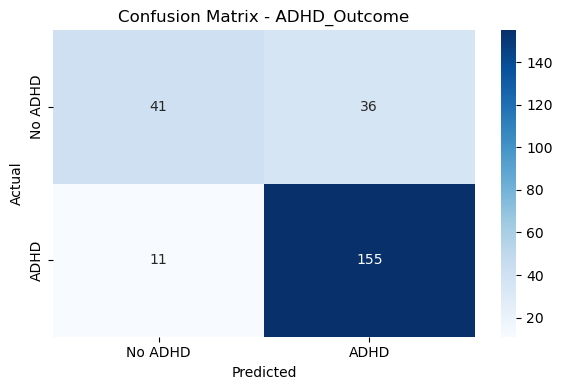

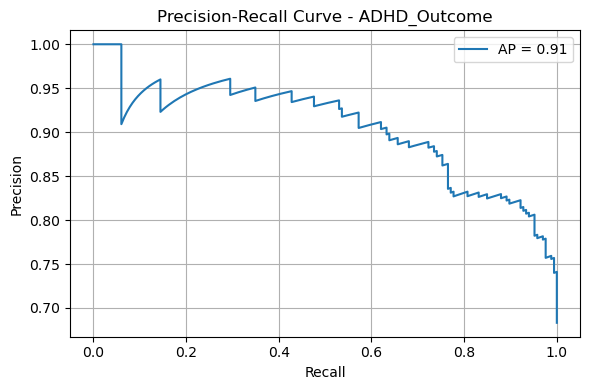

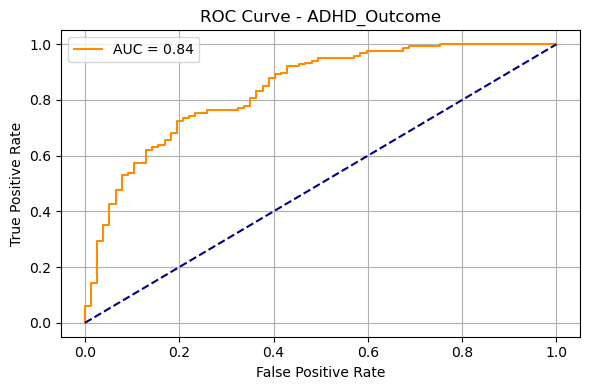

[LightGBM] [Info] Number of positive: 509, number of negative: 510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104864
[LightGBM] [Info] Number of data points in the train set: 1019, number of used features: 427
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

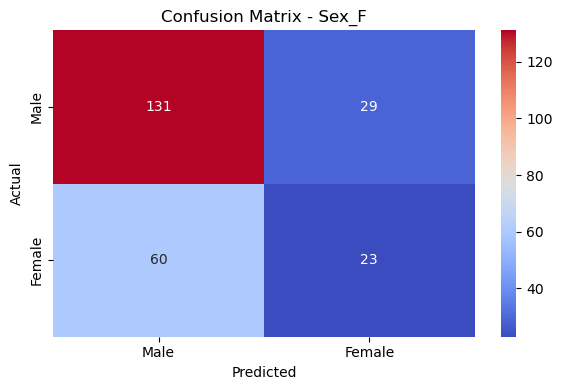

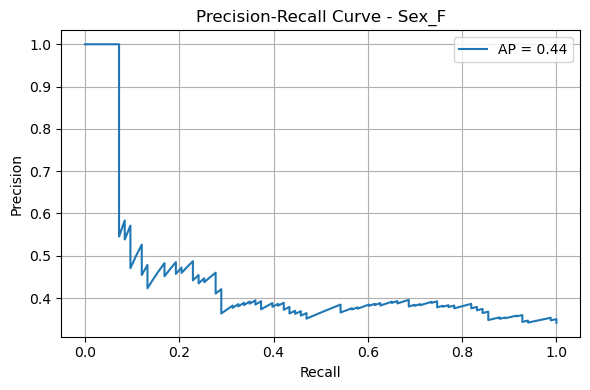

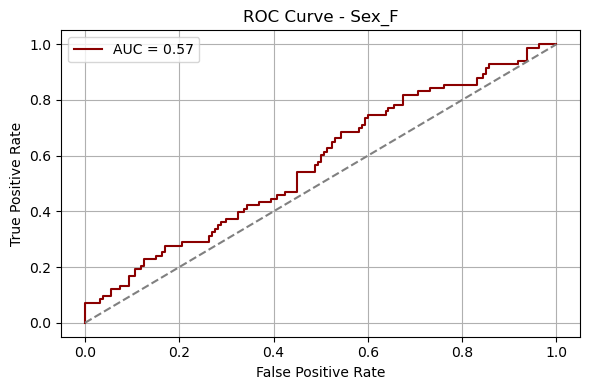

In [3]:
# === 0. Import all libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

# === 1. Load training data ===
data = np.load("final_preprocessed_for_modeling100.npy", allow_pickle=True).item()
functional_matrix = data['functional_matrix_pca']
metadata = pd.DataFrame(data['metadata'])

# === 2. Extract target columns ===
y_adhd = metadata['ADHD_Outcome'].astype(int).values
y_sex = metadata['Sex_F'].astype(int).values
X_meta = metadata.drop(columns=['ADHD_Outcome', 'Sex_F'], errors='ignore')

# === 3. One-hot encode metadata ===
X_meta_encoded = pd.get_dummies(X_meta)
X_combined = np.hstack((functional_matrix, X_meta_encoded.values))

# === 4. ADHD_Outcome Model (XGBoost) ===
X_train_adhd, X_test_adhd, y_train_adhd, y_test_adhd = train_test_split(
    X_combined, y_adhd, test_size=0.2, random_state=42, stratify=y_adhd
)

scaler_adhd = StandardScaler()
X_train_adhd_scaled = scaler_adhd.fit_transform(X_train_adhd)
X_test_adhd_scaled = scaler_adhd.transform(X_test_adhd)

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_adhd_scaled, y_train_adhd)

# Predict ADHD_Outcome
y_pred_adhd = xgb_model.predict(X_test_adhd_scaled)
y_scores_adhd = xgb_model.predict_proba(X_test_adhd_scaled)[:, 1]

print("\n✅ ADHD_Outcome Accuracy:", accuracy_score(y_test_adhd, y_pred_adhd))
print("\n📊 Classification Report for ADHD_Outcome:")
print(classification_report(y_test_adhd, y_pred_adhd))

# === ADHD Confusion Matrix ===
cm_adhd = confusion_matrix(y_test_adhd, y_pred_adhd)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adhd, annot=True, fmt='d', cmap='Blues', xticklabels=["No ADHD", "ADHD"], yticklabels=["No ADHD", "ADHD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ADHD_Outcome")
plt.tight_layout()
plt.show()

# === ADHD Precision-Recall Curve ===
precision_adhd, recall_adhd, _ = precision_recall_curve(y_test_adhd, y_scores_adhd)
ap_adhd = average_precision_score(y_test_adhd, y_scores_adhd)

plt.figure(figsize=(6, 4))
plt.plot(recall_adhd, precision_adhd, label=f'AP = {ap_adhd:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - ADHD_Outcome')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === ADHD ROC Curve ===
fpr_adhd, tpr_adhd, _ = roc_curve(y_test_adhd, y_scores_adhd)
auc_adhd = roc_auc_score(y_test_adhd, y_scores_adhd)

plt.figure(figsize=(6, 4))
plt.plot(fpr_adhd, tpr_adhd, color='darkorange', label=f'AUC = {auc_adhd:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ADHD_Outcome')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === 5. Sex_F model (LightGBM with SMOTE and EarlyStopping) ===
X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(
    X_combined, y_sex, test_size=0.2, random_state=42, stratify=y_sex
)

# Apply SMOTE **only on training data**
smote = SMOTE(random_state=42)
X_train_sex_resampled, y_train_sex_resampled = smote.fit_resample(X_train_sex, y_train_sex)

scaler_sex = StandardScaler()
X_train_sex_scaled = scaler_sex.fit_transform(X_train_sex_resampled)
X_test_sex_scaled = scaler_sex.transform(X_test_sex)

lgbm_model = LGBMClassifier(
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=8,
    num_leaves=64,
    class_weight='balanced',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Stratified 5-Fold CV training
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in skf.split(X_train_sex_scaled, y_train_sex_resampled):
    X_train_fold, X_val_fold = X_train_sex_scaled[train_idx], X_train_sex_scaled[val_idx]
    y_train_fold, y_val_fold = y_train_sex_resampled[train_idx], y_train_sex_resampled[val_idx]
    
    lgbm_model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )

# Predict Sex_F
y_pred_sex = lgbm_model.predict(X_test_sex_scaled)
y_scores_sex = lgbm_model.predict_proba(X_test_sex_scaled)[:, 1]

print("\n✅ Sex_F Accuracy:", accuracy_score(y_test_sex, y_pred_sex))
print("\n📊 Classification Report for Sex_F:")
print(classification_report(y_test_sex, y_pred_sex))

# === Sex Confusion Matrix ===
cm_sex = confusion_matrix(y_test_sex, y_pred_sex)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_sex, annot=True, fmt='d', cmap='coolwarm', xticklabels=["Male", "Female"], yticklabels=["Male", "Female"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Sex_F")
plt.tight_layout()
plt.show()

# === Sex Precision-Recall Curve ===
precision_sex, recall_sex, _ = precision_recall_curve(y_test_sex, y_scores_sex)
ap_sex = average_precision_score(y_test_sex, y_scores_sex)

plt.figure(figsize=(6, 4))
plt.plot(recall_sex, precision_sex, label=f'AP = {ap_sex:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Sex_F')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === Sex ROC Curve ===
fpr_sex, tpr_sex, _ = roc_curve(y_test_sex, y_scores_sex)
auc_sex = roc_auc_score(y_test_sex, y_scores_sex)

plt.figure(figsize=(6, 4))
plt.plot(fpr_sex, tpr_sex, color='darkred', label=f'AUC = {auc_sex:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Sex_F')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === 6. Load test data ===
test_data = np.load("final_preprocessed_for_modeling_test.npy", allow_pickle=True).item()
test_metadata = pd.DataFrame(test_data["metadata"])
test_pca_features = test_data["functional_matrix_pca"]

# === 7. Prepare test metadata ===
test_meta = test_metadata.drop(columns=["Sex_F"], errors='ignore')
test_meta_encoded = pd.get_dummies(test_meta)
test_meta_encoded = test_meta_encoded.reindex(columns=X_meta_encoded.columns, fill_value=0)

# === 8. Pad PCA features if needed ===
required_pca = functional_matrix.shape[1]
if test_pca_features.shape[1] < required_pca:
    padding = np.zeros((test_pca_features.shape[0], required_pca - test_pca_features.shape[1]))
    test_pca_padded = np.hstack((test_pca_features, padding))
else:
    test_pca_padded = test_pca_features

X_test_final = np.hstack((test_pca_padded, test_meta_encoded.values))

# === 9. Predict on final test data ===
X_test_adhd_final_scaled = scaler_adhd.transform(X_test_final)
X_test_sex_final_scaled = scaler_sex.transform(X_test_final)

adhd_preds = xgb_model.predict(X_test_adhd_final_scaled)
sex_preds = lgbm_model.predict(X_test_sex_final_scaled)

# === 10. Format submission ===
submission = pd.DataFrame({
    "ADHD_Outcome": adhd_preds,
    "Sex_F": sex_preds
})
if "participant_id" in test_metadata.columns:
    submission.insert(0, "participant_id", test_metadata["participant_id"])

# Save submission if needed
# submission.to_csv("submission.csv", index=False)


3RD CODE 

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:11:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ ADHD_Outcome Accuracy: 0.8065843621399177

📊 Classification Report for ADHD_Outcome:
              precision    recall  f1-score   support

           0       0.79      0.53      0.64        77
           1       0.81      0.93      0.87       166

    accuracy                           0.81       243
   macro avg       0.80      0.73      0.75       243
weighted avg       0.80      0.81      0.79       243



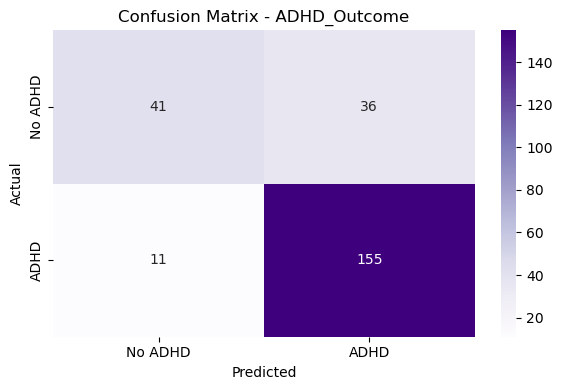

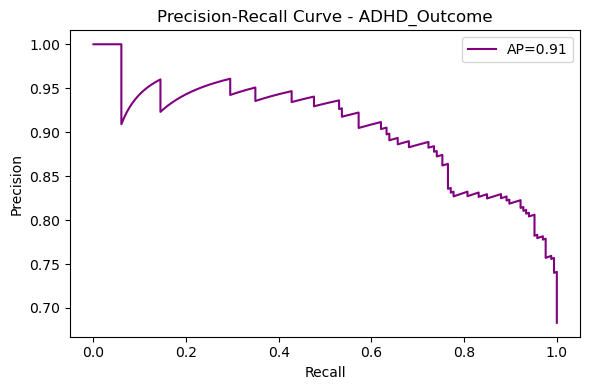

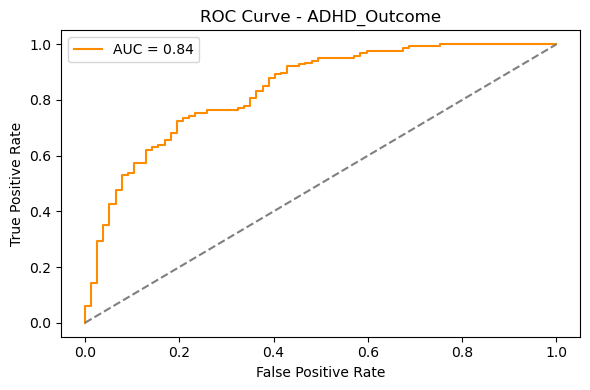

[LightGBM] [Info] Number of positive: 637, number of negative: 637
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106287
[LightGBM] [Info] Number of data points in the train set: 1274, number of used features: 428
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

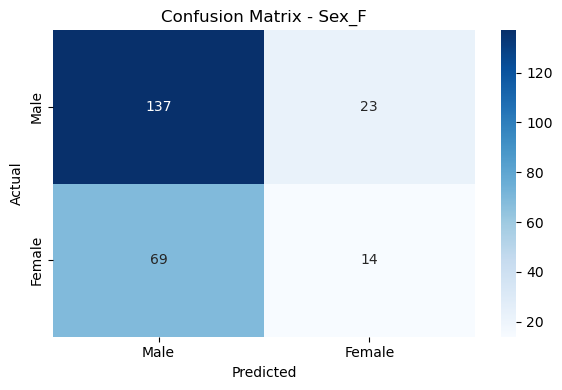

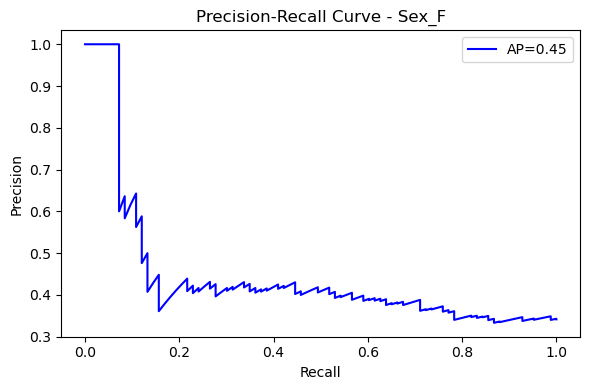

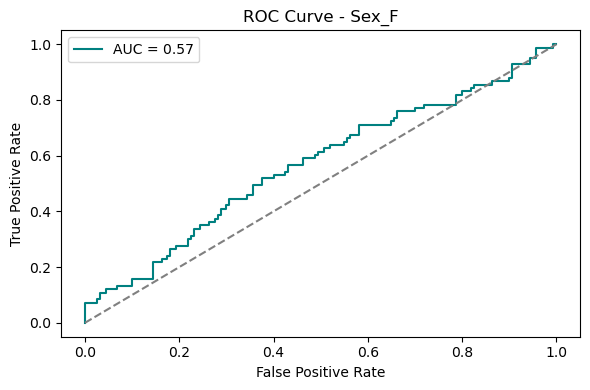

In [ ]:
# === 0. Import all libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score, roc_curve, auc
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# === 1. Load training data ===
data = np.load("final_preprocessed_for_modeling100.npy", allow_pickle=True).item()
functional_matrix = data['functional_matrix_pca']
metadata = pd.DataFrame(data['metadata'])

# === 2. Extract target columns ===
y_adhd = metadata['ADHD_Outcome'].astype(int).values
y_sex = metadata['Sex_F'].astype(int).values
X_meta = metadata.drop(columns=['ADHD_Outcome', 'Sex_F'], errors='ignore')

# === 3. One-hot encode metadata ===
X_meta_encoded = pd.get_dummies(X_meta)
X_combined = np.hstack((functional_matrix, X_meta_encoded.values))

# === 4. ADHD_Outcome Model (XGBoost) ===
X_train_adhd, X_test_adhd, y_train_adhd, y_test_adhd = train_test_split(
    X_combined, y_adhd, test_size=0.2, random_state=42, stratify=y_adhd
)

scaler_adhd = StandardScaler()
X_train_adhd_scaled = scaler_adhd.fit_transform(X_train_adhd)
X_test_adhd_scaled = scaler_adhd.transform(X_test_adhd)

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_adhd_scaled, y_train_adhd)

# Predict ADHD_Outcome
y_pred_adhd = xgb_model.predict(X_test_adhd_scaled)
y_proba_adhd = xgb_model.predict_proba(X_test_adhd_scaled)[:, 1]

print("\n✅ ADHD_Outcome Accuracy:", accuracy_score(y_test_adhd, y_pred_adhd))
print("\n📊 Classification Report for ADHD_Outcome:")
print(classification_report(y_test_adhd, y_pred_adhd))

# === Confusion Matrix ADHD ===
cm_adhd = confusion_matrix(y_test_adhd, y_pred_adhd)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adhd, annot=True, fmt='d', cmap='Purples',
            xticklabels=["No ADHD", "ADHD"], yticklabels=["No ADHD", "ADHD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ADHD_Outcome")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve ADHD ===
precision_adhd, recall_adhd, _ = precision_recall_curve(y_test_adhd, y_proba_adhd)
avg_precision_adhd = average_precision_score(y_test_adhd, y_proba_adhd)

plt.figure(figsize=(6, 4))
plt.plot(recall_adhd, precision_adhd, label=f'AP={avg_precision_adhd:.2f}', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - ADHD_Outcome')
plt.legend()
plt.tight_layout()
plt.show()

# === ROC Curve ADHD ===
fpr_adhd, tpr_adhd, _ = roc_curve(y_test_adhd, y_proba_adhd)
roc_auc_adhd = auc(fpr_adhd, tpr_adhd)

plt.figure(figsize=(6, 4))
plt.plot(fpr_adhd, tpr_adhd, color='darkorange', label=f"AUC = {roc_auc_adhd:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ADHD_Outcome")
plt.legend()
plt.tight_layout()
plt.show()

# === 5. Sex_F model (LightGBM with SMOTE) ===
X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(
    X_combined, y_sex, test_size=0.2, random_state=42, stratify=y_sex
)

smote = SMOTE(random_state=42)
X_train_sex_resampled, y_train_sex_resampled = smote.fit_resample(X_train_sex, y_train_sex)

scaler_sex = StandardScaler()
X_train_sex_scaled = scaler_sex.fit_transform(X_train_sex_resampled)
X_test_sex_scaled = scaler_sex.transform(X_test_sex)

lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    class_weight='balanced',
    random_state=42
)
lgbm_model.fit(X_train_sex_scaled, y_train_sex_resampled)

# Predict Sex_F
y_pred_sex = lgbm_model.predict(X_test_sex_scaled)
y_proba_sex = lgbm_model.predict_proba(X_test_sex_scaled)[:, 1]

print("\n✅ Sex_F Accuracy:", accuracy_score(y_test_sex, y_pred_sex))
print("\n📊 Classification Report for Sex_F:")
print(classification_report(y_test_sex, y_pred_sex))

# === Confusion Matrix Sex_F ===
cm_sex = confusion_matrix(y_test_sex, y_pred_sex)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_sex, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Male", "Female"], yticklabels=["Male", "Female"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Sex_F")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve Sex_F ===
precision_sex, recall_sex, _ = precision_recall_curve(y_test_sex, y_proba_sex)
avg_precision_sex = average_precision_score(y_test_sex, y_proba_sex)

plt.figure(figsize=(6, 4))
plt.plot(recall_sex, precision_sex, label=f'AP={avg_precision_sex:.2f}', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Sex_F')
plt.legend()
plt.tight_layout()
plt.show()

# === ROC Curve Sex_F ===
fpr_sex, tpr_sex, _ = roc_curve(y_test_sex, y_proba_sex)
roc_auc_sex = auc(fpr_sex, tpr_sex)

plt.figure(figsize=(6, 4))
plt.plot(fpr_sex, tpr_sex, color='teal', label=f"AUC = {roc_auc_sex:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Sex_F")
plt.legend()
plt.tight_layout()
plt.show()

# === 6. Load test data ===
test_data = np.load("final_preprocessed_for_modeling_test.npy", allow_pickle=True).item()
test_metadata = pd.DataFrame(test_data["metadata"])
test_pca_features = test_data["functional_matrix_pca"]

# === 7. Prepare test metadata ===
test_meta = test_metadata.drop(columns=["Sex_F"], errors='ignore')
test_meta_encoded = pd.get_dummies(test_meta)
test_meta_encoded = test_meta_encoded.reindex(columns=X_meta_encoded.columns, fill_value=0)

# === 8. Pad PCA features if needed ===
required_pca = functional_matrix.shape[1]
if test_pca_features.shape[1] < required_pca:
    padding = np.zeros((test_pca_features.shape[0], required_pca - test_pca_features.shape[1]))
    test_pca_padded = np.hstack((test_pca_features, padding))
else:
    test_pca_padded = test_pca_features

X_test_final = np.hstack((test_pca_padded, test_meta_encoded.values))

# === 9. Predict on final test data ===
X_test_adhd_final_scaled = scaler_adhd.transform(X_test_final)
X_test_sex_final_scaled = scaler_sex.transform(X_test_final)

adhd_preds = xgb_model.predict(X_test_adhd_final_scaled)
sex_preds = lgbm_model.predict(X_test_sex_final_scaled)

# === 10. Format submission ===
submission = pd.DataFrame({
    "ADHD_Outcome": adhd_preds,
    "Sex_F": sex_preds
})
if "participant_id" in test_metadata.columns:
    submission.insert(0, "participant_id", test_metadata["participant_id"])

# Save submission if needed
# submission.to_csv("submission.csv", index=False)


# 76.135

CODE 4 XGBOOST & RANDOM FOREST 78%

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:15:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ ADHD_Outcome Accuracy: 0.7942386831275721

📊 Classification Report for ADHD_Outcome:
              precision    recall  f1-score   support

           0       0.65      0.49      0.56        65
           1       0.83      0.90      0.87       178

    accuracy                           0.79       243
   macro avg       0.74      0.70      0.71       243
weighted avg       0.78      0.79      0.78       243



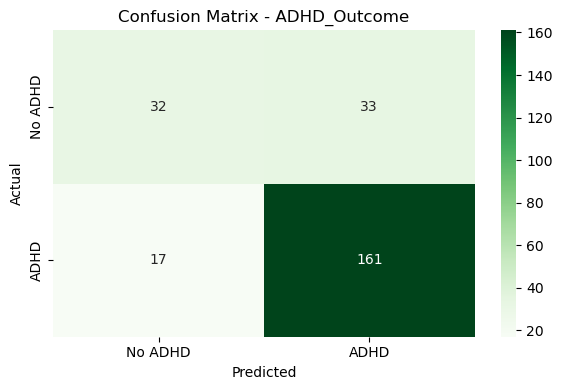

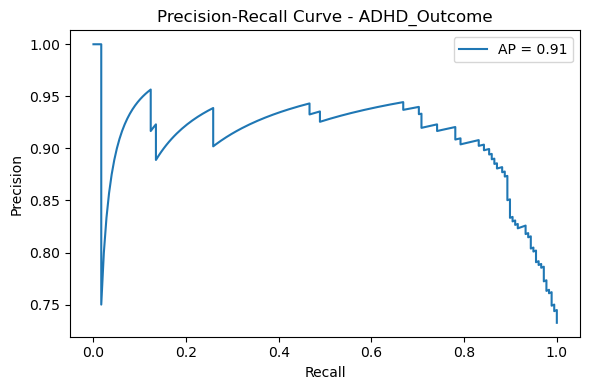

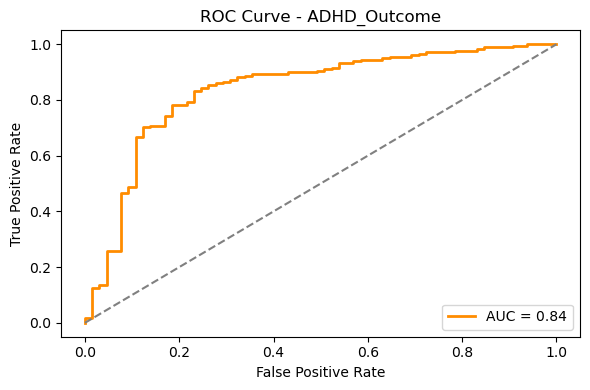

✅ Sex_F Accuracy: 0.774294670846395

📊 Classification Report for Sex_F:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       160
           1       0.82      0.70      0.76       159

    accuracy                           0.77       319
   macro avg       0.78      0.77      0.77       319
weighted avg       0.78      0.77      0.77       319



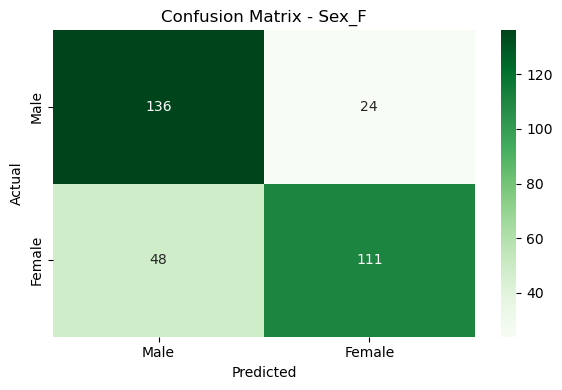

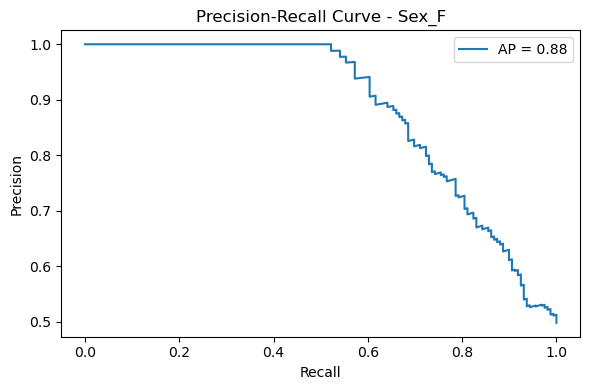

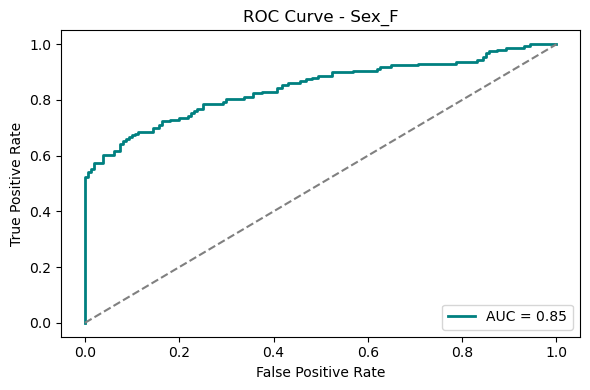

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [6]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Load training data ===
data = np.load("final_preprocessed_for_modeling100.npy", allow_pickle=True).item()
functional_matrix = data['functional_matrix_pca']
metadata = pd.DataFrame(data['metadata'])

# === 2. Extract target columns ===
y_adhd = metadata['ADHD_Outcome'].astype(int).values
y_sex = metadata['Sex_F'].astype(int).values
X_meta = metadata.drop(columns=['ADHD_Outcome', 'Sex_F'], errors='ignore')

# === 3. One-hot encode metadata ===
X_meta_encoded = pd.get_dummies(X_meta)
X_combined = np.hstack((functional_matrix, X_meta_encoded.values))

# === 4. ADHD_Outcome model (XGBoost) ===
X_train_adhd, X_test_adhd, y_train_adhd, y_test_adhd = train_test_split(
    X_combined, y_adhd, test_size=0.2, random_state=42
)

scaler_adhd = StandardScaler()
X_train_adhd_scaled = scaler_adhd.fit_transform(X_train_adhd)
X_test_adhd_scaled = scaler_adhd.transform(X_test_adhd)

xgb_model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train_adhd_scaled, y_train_adhd)
y_pred_adhd = xgb_model.predict(X_test_adhd_scaled)

print("✅ ADHD_Outcome Accuracy:", accuracy_score(y_test_adhd, y_pred_adhd))
print("\n📊 Classification Report for ADHD_Outcome:")
print(classification_report(y_test_adhd, y_pred_adhd))

# === ADHD Confusion Matrix ===
cm_adhd = confusion_matrix(y_test_adhd, y_pred_adhd)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adhd, annot=True, fmt='d', cmap="Greens", xticklabels=["No ADHD", "ADHD"], yticklabels=["No ADHD", "ADHD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ADHD_Outcome")
plt.tight_layout()
plt.show()

# === ADHD Precision-Recall Curve ===
y_proba_adhd = xgb_model.predict_proba(X_test_adhd_scaled)[:, 1]
precision, recall, _ = precision_recall_curve(y_test_adhd, y_proba_adhd)
ap_score = average_precision_score(y_test_adhd, y_proba_adhd)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"AP = {ap_score:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - ADHD_Outcome")
plt.legend()
plt.tight_layout()
plt.show()
from sklearn.metrics import roc_curve, auc

# === ADHD ROC Curve ===
fpr_adhd, tpr_adhd, _ = roc_curve(y_test_adhd, y_proba_adhd)
roc_auc_adhd = auc(fpr_adhd, tpr_adhd)

plt.figure(figsize=(6, 4))
plt.plot(fpr_adhd, tpr_adhd, color='darkorange', lw=2, label=f'AUC = {roc_auc_adhd:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ADHD_Outcome")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# === 5. Sex_F model (RandomForest + SMOTE) ===
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_combined, y_sex)

X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

scaler_sex = StandardScaler()
X_train_sex_scaled = scaler_sex.fit_transform(X_train_sex)
X_test_sex_scaled = scaler_sex.transform(X_test_sex)

rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_train_sex_scaled, y_train_sex)
y_pred_sex = rf_model.predict(X_test_sex_scaled)

print("✅ Sex_F Accuracy:", accuracy_score(y_test_sex, y_pred_sex))
print("\n📊 Classification Report for Sex_F:")
print(classification_report(y_test_sex, y_pred_sex))

# === Sex_F Confusion Matrix ===
cm_sex = confusion_matrix(y_test_sex, y_pred_sex)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_sex, annot=True, fmt='d', cmap="Greens", xticklabels=["Male", "Female"], yticklabels=["Male", "Female"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Sex_F")
plt.tight_layout()
plt.show()

# === Sex Precision-Recall Curve ===
y_proba_sex = rf_model.predict_proba(X_test_sex_scaled)[:, 1]
precision, recall, _ = precision_recall_curve(y_test_sex, y_proba_sex)
ap_score = average_precision_score(y_test_sex, y_proba_sex)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"AP = {ap_score:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Sex_F")
plt.legend()
plt.tight_layout()
plt.show()

# === Sex ROC Curve ===
fpr_sex, tpr_sex, _ = roc_curve(y_test_sex, y_proba_sex)
roc_auc_sex = auc(fpr_sex, tpr_sex)

plt.figure(figsize=(6, 4))
plt.plot(fpr_sex, tpr_sex, color='teal', lw=2, label=f'AUC = {roc_auc_sex:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Sex_F")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# === 6. Load test data ===
test_data = np.load("final_preprocessed_for_modeling_test.npy", allow_pickle=True).item()
test_metadata = pd.DataFrame(test_data["metadata"])
test_pca_features = test_data["functional_matrix_pca"]

# === 7. Prepare test metadata ===
test_meta = test_metadata.drop(columns=["Sex_F"], errors='ignore')
test_meta_encoded = pd.get_dummies(test_meta)
test_meta_encoded = test_meta_encoded.reindex(columns=X_meta_encoded.columns, fill_value=0)

# === 8. Pad PCA features if needed ===
required_pca = functional_matrix.shape[1]
if test_pca_features.shape[1] < required_pca:
    padding = np.zeros((test_pca_features.shape[0], required_pca - test_pca_features.shape[1]))
    test_pca_padded = np.hstack((test_pca_features, padding))
else:
    test_pca_padded = test_pca_features

X_test_final = np.hstack((test_pca_padded, test_meta_encoded.values))

# === 9. Predict on test data ===
X_test_adhd_final_scaled = scaler_adhd.transform(X_test_final)
X_test_sex_final_scaled = scaler_sex.transform(X_test_final)

adhd_preds = xgb_model.predict(X_test_adhd_final_scaled)
sex_preds = rf_model.predict(X_test_sex_final_scaled)

# === 10. Format submission ===
submission = pd.DataFrame({
    "ADHD_Outcome": adhd_preds,
    "Sex_F": sex_preds
})
if "participant_id" in test_metadata.columns:
    submission.insert(0, "participant_id", test_metadata["participant_id"])

# 76.153

CODE 5 XGBClassifier from XGBoost  &RandomForestClassifier

✅ ADHD_Outcome Accuracy: 0.7860082304526749
              precision    recall  f1-score   support

           0       0.70      0.57      0.63        77
           1       0.82      0.89      0.85       166

    accuracy                           0.79       243
   macro avg       0.76      0.73      0.74       243
weighted avg       0.78      0.79      0.78       243



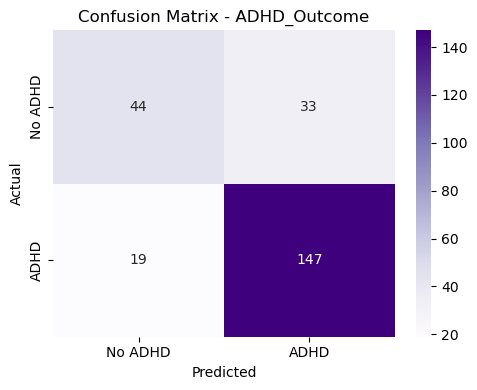

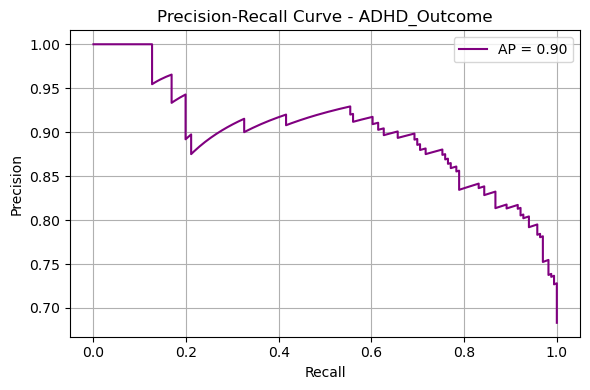

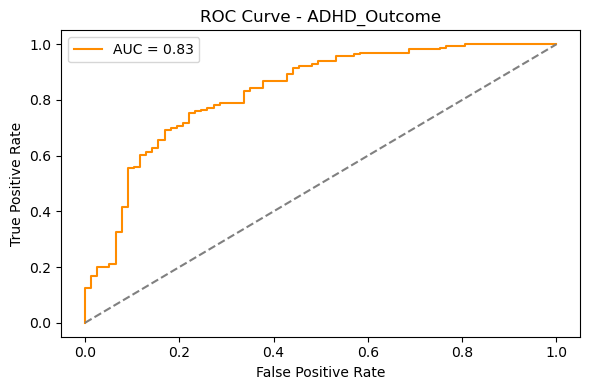

✅ Sex_F Accuracy: 0.6707818930041153
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       160
           1       0.53      0.36      0.43        83

    accuracy                           0.67       243
   macro avg       0.62      0.60      0.60       243
weighted avg       0.65      0.67      0.65       243



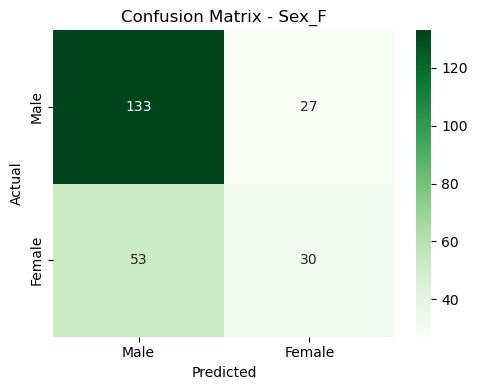

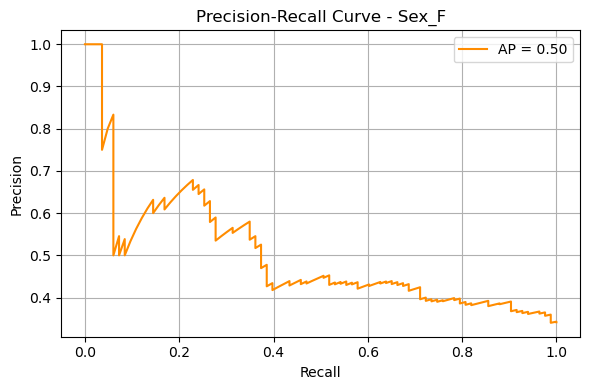

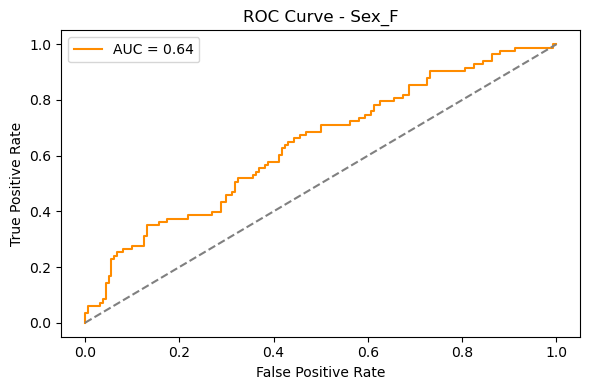

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Load Data ===
data = np.load('final_preprocessed_for_modeling100.npy', allow_pickle=True).item()
metadata = data['metadata']
X_pca = data['functional_matrix_pca']

# === 2. Prepare Features and Labels ===
y_adhd = metadata['ADHD_Outcome']
y_sex = metadata['Sex_F']
X_meta = metadata.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F'])
X_combined = np.hstack([X_meta.to_numpy(), X_pca])

# === 3. ADHD_Outcome Model ===
X_train_adhd, X_test_adhd, y_train_adhd, y_test_adhd = train_test_split(
    X_combined, y_adhd, test_size=0.2, random_state=42, stratify=y_adhd
)

sm = SMOTE(random_state=42)
X_train_res_adhd, y_train_res_adhd = sm.fit_resample(X_train_adhd, y_train_adhd)

scaler_adhd = StandardScaler()
X_train_res_adhd = scaler_adhd.fit_transform(X_train_res_adhd)
X_test_adhd = scaler_adhd.transform(X_test_adhd)

model_adhd = XGBClassifier(random_state=42, n_estimators=300, max_depth=5, learning_rate=0.05)
model_adhd.fit(X_train_res_adhd, y_train_res_adhd)

y_pred_adhd = model_adhd.predict(X_test_adhd)
print("✅ ADHD_Outcome Accuracy:", accuracy_score(y_test_adhd, y_pred_adhd))
print(classification_report(y_test_adhd, y_pred_adhd))

# === Confusion Matrix - ADHD ===
cm_adhd = confusion_matrix(y_test_adhd, y_pred_adhd)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_adhd, annot=True, fmt='d', cmap='Purples', xticklabels=["No ADHD", "ADHD"], yticklabels=["No ADHD", "ADHD"])
plt.title("Confusion Matrix - ADHD_Outcome")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve - ADHD ===
y_score_adhd = model_adhd.predict_proba(X_test_adhd)[:, 1]
precision_adhd, recall_adhd, _ = precision_recall_curve(y_test_adhd, y_score_adhd)
ap_adhd = average_precision_score(y_test_adhd, y_score_adhd)

plt.figure(figsize=(6, 4))
plt.plot(recall_adhd, precision_adhd, color='purple', label=f'AP = {ap_adhd:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - ADHD_Outcome")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === ROC Curve - ADHD ===
fpr_adhd, tpr_adhd, _ = roc_curve(y_test_adhd, y_score_adhd)
roc_auc_adhd = auc(fpr_adhd, tpr_adhd)

plt.figure(figsize=(6, 4))
plt.plot(fpr_adhd, tpr_adhd, color='darkorange', label=f'AUC = {roc_auc_adhd:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ADHD_Outcome')
plt.legend()
plt.tight_layout()
plt.show()

# === 4. Sex_F Model ===
X_meta_arr = X_meta.to_numpy()
X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(
    X_meta_arr, y_sex, test_size=0.2, random_state=42, stratify=y_sex
)

X_train_res_sex, y_train_res_sex = sm.fit_resample(X_train_sex, y_train_sex)

scaler_sex = StandardScaler()
X_train_res_sex = scaler_sex.fit_transform(X_train_res_sex)
X_test_sex = scaler_sex.transform(X_test_sex)

model_sex = XGBClassifier(random_state=42, n_estimators=300, max_depth=5, learning_rate=0.05)
model_sex.fit(X_train_res_sex, y_train_res_sex)

y_pred_sex = model_sex.predict(X_test_sex)
print("✅ Sex_F Accuracy:", accuracy_score(y_test_sex, y_pred_sex))
print(classification_report(y_test_sex, y_pred_sex))

# === Confusion Matrix - Sex_F ===
cm_sex = confusion_matrix(y_test_sex, y_pred_sex)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_sex, annot=True, fmt='d', cmap='Greens', xticklabels=["Male", "Female"], yticklabels=["Male", "Female"])
plt.title("Confusion Matrix - Sex_F")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve - Sex_F ===
y_score_sex = model_sex.predict_proba(X_test_sex)[:, 1]
precision_sex, recall_sex, _ = precision_recall_curve(y_test_sex, y_score_sex)
ap_sex = average_precision_score(y_test_sex, y_score_sex)

plt.figure(figsize=(6, 4))
plt.plot(recall_sex, precision_sex, color='darkorange', label=f'AP = {ap_sex:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Sex_F")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === ROC Curve - Sex_F ===
fpr_sex, tpr_sex, _ = roc_curve(y_test_sex, y_score_sex)
roc_auc_sex = auc(fpr_sex, tpr_sex)

plt.figure(figsize=(6, 4))
plt.plot(fpr_sex, tpr_sex, color='darkorange', label=f'AUC = {roc_auc_sex:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Sex_F')
plt.legend()
plt.tight_layout()
plt.show()


FINAL CODE

CODE 6 XGBClassifier & StackingClassifier (RF + LGBM + CatBoost → Logistic Regression)


--- ADHD_Outcome Model ---


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:27:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ADHD_Outcome Accuracy: 0.8189300411522634
              precision    recall  f1-score   support

           0       0.81      0.56      0.66        77
           1       0.82      0.94      0.88       166

    accuracy                           0.82       243
   macro avg       0.82      0.75      0.77       243
weighted avg       0.82      0.82      0.81       243

Confusion Matrix (ADHD_Outcome):
 [[ 43  34]
 [ 10 156]]


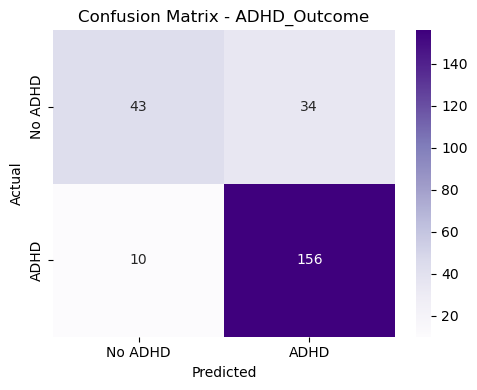

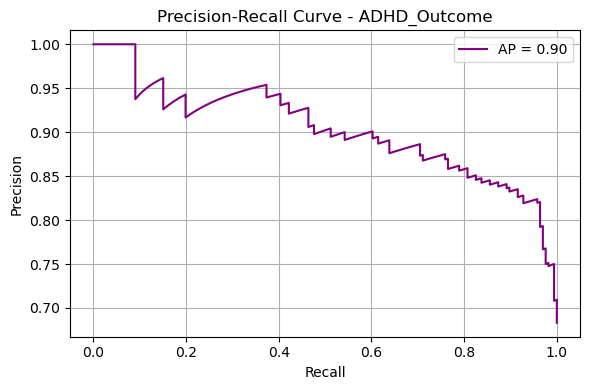

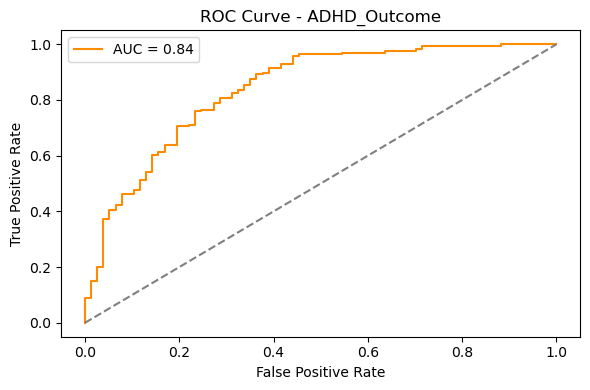


--- Sex_F Model ---
[LightGBM] [Info] Number of positive: 637, number of negative: 637
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3972
[LightGBM] [Info] Number of data points in the train set: 1274, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 509, number of negative: 510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3971
[LightGBM] [Info] Number of data points in the train set: 1019, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499509 -> initscore=-0.001963
[LightGBM] [Info] Start training from score -0.001963
[LightGBM] [Info] Number of positive: 509, number of neg

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sex_F Accuracy: 0.6296296296296297
              precision    recall  f1-score   support

           0       0.70      0.78      0.73       160
           1       0.45      0.35      0.39        83

    accuracy                           0.63       243
   macro avg       0.57      0.56      0.56       243
weighted avg       0.61      0.63      0.62       243

Confusion Matrix (Sex_F):
 [[124  36]
 [ 54  29]]


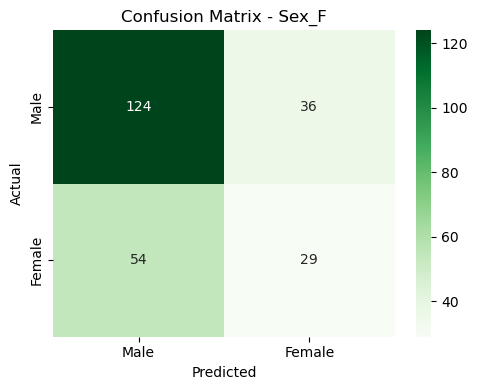

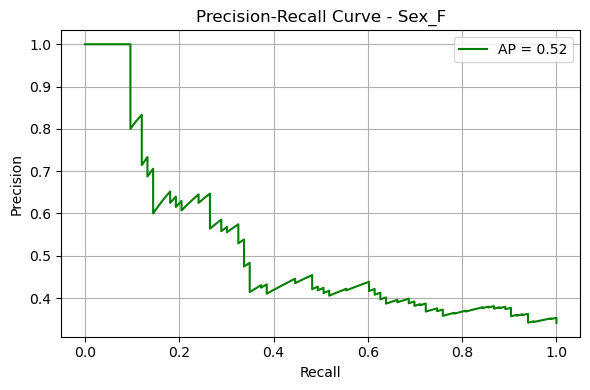

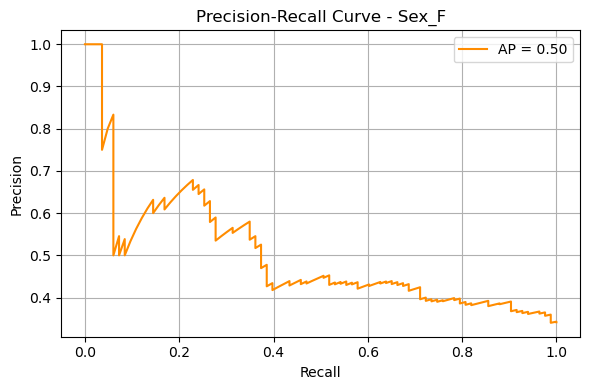

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression

# Load data
data = np.load("final_preprocessed_for_modeling100.npy", allow_pickle=True).item()
X_func = data["functional_matrix_pca"]
X_meta = data["metadata"]
y_adhd = X_meta["ADHD_Outcome"].values
y_sex = X_meta["Sex_F"].values

# Drop target columns
X_meta = X_meta.drop(columns=["ADHD_Outcome", "Sex_F"])

# Categorical feature indices for SMOTENC
cat_indices = [i for i, col in enumerate(X_meta.columns) if X_meta[col].dtype == "object" or len(X_meta[col].unique()) <= 4]

# One-hot encode categorical features
X_meta = pd.get_dummies(X_meta, drop_first=True)
X_meta_arr = X_meta.values

# Scale functional PCA features
scaler_func = StandardScaler()
X_func_scaled = scaler_func.fit_transform(X_func)

# Combine both for ADHD model
X_combined = np.concatenate([X_func_scaled, X_meta_arr], axis=1)

# ======== ADHD_Outcome MODEL ========
print("\n--- ADHD_Outcome Model ---")
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_adhd, stratify=y_adhd, test_size=0.2, random_state=42)

adhd_model = XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42)
adhd_model.fit(X_train, y_train)
y_pred_adhd = adhd_model.predict(X_test)

print("ADHD_Outcome Accuracy:", accuracy_score(y_test, y_pred_adhd))
print(classification_report(y_test, y_pred_adhd))
print("Confusion Matrix (ADHD_Outcome):\n", confusion_matrix(y_test, y_pred_adhd))

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_adhd), annot=True, fmt='d', cmap='Purples',
            xticklabels=["No ADHD", "ADHD"], yticklabels=["No ADHD", "ADHD"])
plt.title("Confusion Matrix - ADHD_Outcome")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Plot precision-recall curve
y_score_adhd = adhd_model.predict_proba(X_test)[:, 1]
precision_adhd, recall_adhd, _ = precision_recall_curve(y_test, y_score_adhd)
ap_adhd = average_precision_score(y_test, y_score_adhd)

plt.figure(figsize=(6, 4))
plt.plot(recall_adhd, precision_adhd, color='purple', label=f'AP = {ap_adhd:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - ADHD_Outcome")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === ROC Curve - ADHD ===
fpr_adhd, tpr_adhd, _ = roc_curve(y_test_adhd, y_score_adhd)
roc_auc_adhd = auc(fpr_adhd, tpr_adhd)

plt.figure(figsize=(6, 4))
plt.plot(fpr_adhd, tpr_adhd, color='darkorange', label=f'AUC = {roc_auc_adhd:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ADHD_Outcome')
plt.legend()
plt.tight_layout()
plt.show()


# ======== Sex_F MODEL ========
print("\n--- Sex_F Model ---")
X_train, X_test, y_train, y_test = train_test_split(X_meta_arr, y_sex, stratify=y_sex, test_size=0.2, random_state=42)

# SMOTE-NC for categorical features
smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42)
X_res, y_res = smote_nc.fit_resample(X_train, y_train)

# Feature selection
selector = SelectKBest(mutual_info_classif, k=30)
X_res_sel = selector.fit_transform(X_res, y_res)
X_test_sel = selector.transform(X_test)

# Stacking ensemble model
sex_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)),
        ('lgb', LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42)),
        ('cat', CatBoostClassifier(verbose=0, iterations=200, learning_rate=0.05, depth=6, random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=500),
    cv=5,
    passthrough=True
)

sex_model.fit(X_res_sel, y_res)
y_pred_sex = sex_model.predict(X_test_sel)

print("Sex_F Accuracy:", accuracy_score(y_test, y_pred_sex))
print(classification_report(y_test, y_pred_sex))
print("Confusion Matrix (Sex_F):\n", confusion_matrix(y_test, y_pred_sex))

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_sex), annot=True, fmt='d', cmap='Greens',
            xticklabels=["Male", "Female"], yticklabels=["Male", "Female"])
plt.title("Confusion Matrix - Sex_F")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Plot precision-recall curve
y_score_sex = sex_model.predict_proba(X_test_sel)[:, 1]
precision_sex, recall_sex, _ = precision_recall_curve(y_test, y_score_sex)
ap_sex = average_precision_score(y_test, y_score_sex)

plt.figure(figsize=(6, 4))
plt.plot(recall_sex, precision_sex, color='green', label=f'AP = {ap_sex:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Sex_F")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Precision-Recall Curve - Sex_F ===
y_score_sex = model_sex.predict_proba(X_test_sex)[:, 1]
precision_sex, recall_sex, _ = precision_recall_curve(y_test_sex, y_score_sex)
ap_sex = average_precision_score(y_test_sex, y_score_sex)

plt.figure(figsize=(6, 4))
plt.plot(recall_sex, precision_sex, color='darkorange', label=f'AP = {ap_sex:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Sex_F")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Low Accuracy

CODE 7 MLPClassifier


✅ ADHD_Outcome Accuracy: 0.7325102880658436

📊 Classification Report for ADHD_Outcome:
              precision    recall  f1-score   support

           0       0.50      0.55      0.53        65
           1       0.83      0.80      0.81       178

    accuracy                           0.73       243
   macro avg       0.67      0.68      0.67       243
weighted avg       0.74      0.73      0.74       243



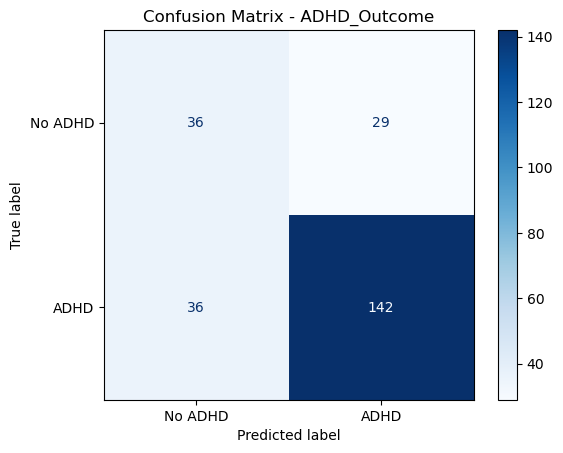


📋 ADHD Classification Report Table:
              precision    recall  f1-score    support
0              0.500000  0.553846  0.525547   65.00000
1              0.830409  0.797753  0.813754  178.00000
accuracy       0.732510  0.732510  0.732510    0.73251
macro avg      0.665205  0.675799  0.669651  243.00000
weighted avg   0.742028  0.732510  0.736661  243.00000


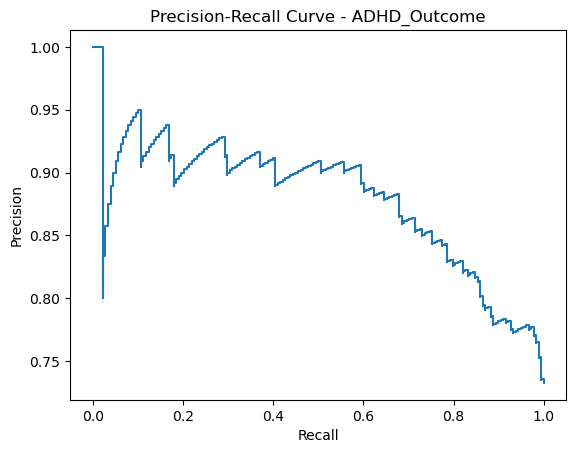

✅ Sex_F Accuracy: 0.5432098765432098

📊 Classification Report for Sex_F:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       171
           1       0.28      0.35      0.31        72

    accuracy                           0.54       243
   macro avg       0.49      0.49      0.48       243
weighted avg       0.57      0.54      0.56       243



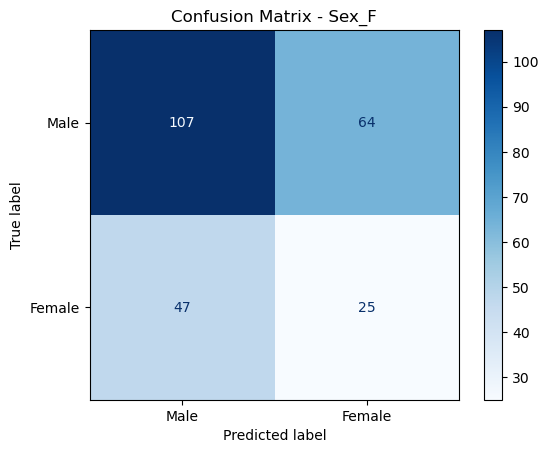


📋 Sex_F Classification Report Table:
              precision    recall  f1-score    support
0              0.694805  0.625731  0.658462  171.00000
1              0.280899  0.347222  0.310559   72.00000
accuracy       0.543210  0.543210  0.543210    0.54321
macro avg      0.487852  0.486477  0.484510  243.00000
weighted avg   0.572166  0.543210  0.555379  243.00000


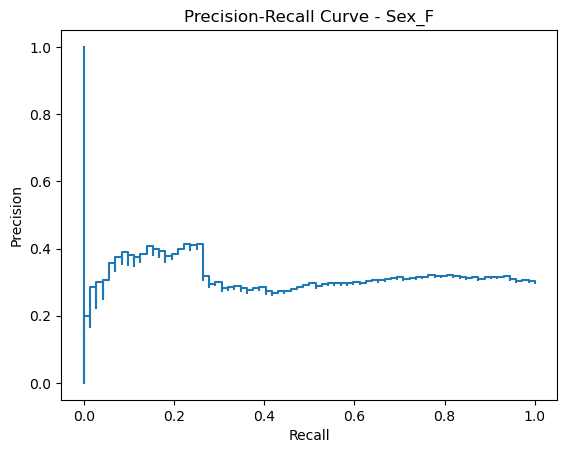

In [12]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from tabulate import tabulate  # For boxed tables

# === 1. Load Data ===
data = np.load('final_preprocessed_for_modeling100.npy', allow_pickle=True).item()

# Extracting PCA features and metadata
functional_matrix = data['functional_matrix_pca']
metadata = pd.DataFrame(data['metadata'])

# === 2. Extract target columns ===
y_adhd = metadata['ADHD_Outcome'].astype(int).values
y_sex = metadata['Sex_F'].astype(int).values
X_meta = metadata.drop(columns=['ADHD_Outcome', 'Sex_F'], errors='ignore')

# === 3. One-hot encode metadata ===
X_meta_encoded = pd.get_dummies(X_meta)
X_combined = np.hstack((functional_matrix, X_meta_encoded.values))

# === 4. Split data ===
X_train, X_test, y_train_adhd, y_test_adhd, y_train_sex, y_test_sex = train_test_split(
    X_combined, y_adhd, y_sex, test_size=0.2, random_state=42
)

# === 5. Standardize features ===
scaler_adhd = StandardScaler()
X_train_adhd_scaled = scaler_adhd.fit_transform(X_train)
X_test_adhd_scaled = scaler_adhd.transform(X_test)

scaler_sex = StandardScaler()
X_train_sex_scaled = scaler_sex.fit_transform(X_train)
X_test_sex_scaled = scaler_sex.transform(X_test)

# === 6. ADHD Model (MLP) ===
mlp_adhd = MLPClassifier(hidden_layer_sizes=(256, 128), activation='relu', solver='adam', max_iter=500)
mlp_adhd.fit(X_train_adhd_scaled, y_train_adhd)

# === 7. ADHD Predictions & Evaluation ===
y_pred_adhd = mlp_adhd.predict(X_test_adhd_scaled)
print("✅ ADHD_Outcome Accuracy:", accuracy_score(y_test_adhd, y_pred_adhd))

# === 7.1 Confusion Matrix for ADHD ===
cm_adhd = confusion_matrix(y_test_adhd, y_pred_adhd)
disp_adhd = ConfusionMatrixDisplay(confusion_matrix=cm_adhd, display_labels=["No ADHD", "ADHD"])
disp_adhd.plot(cmap='Blues')
plt.title("Confusion Matrix - ADHD_Outcome")
plt.show()

# === 7.2 Classification Report Table for ADHD ===
report_adhd = classification_report(y_test_adhd, y_pred_adhd, output_dict=True)
report_adhd_df = pd.DataFrame(report_adhd).transpose()
print("\n📋 ADHD Classification Report Table (Boxed):")
print(tabulate(report_adhd_df.reset_index(), headers='keys', tablefmt='fancy_grid', showindex=False))

# === 7.3 Precision-Recall Curve for ADHD ===
y_scores_adhd = mlp_adhd.predict_proba(X_test_adhd_scaled)[:, 1]
precision_adhd, recall_adhd, _ = precision_recall_curve(y_test_adhd, y_scores_adhd)
disp_pr_adhd = PrecisionRecallDisplay(precision=precision_adhd, recall=recall_adhd)
disp_pr_adhd.plot()
plt.title("Precision-Recall Curve - ADHD_Outcome")
plt.show()

# === 8. Sex Model (MLP + SMOTE) ===
smote = SMOTE(random_state=42)
X_train_sex_resampled, y_train_sex_resampled = smote.fit_resample(X_train_sex_scaled, y_train_sex)

mlp_sex = MLPClassifier(hidden_layer_sizes=(256, 128), activation='relu', solver='adam', max_iter=500)
mlp_sex.fit(X_train_sex_resampled, y_train_sex_resampled)

# === 9. Sex Predictions & Evaluation ===
y_pred_sex = mlp_sex.predict(X_test_sex_scaled)
print("✅ Sex_F Accuracy:", accuracy_score(y_test_sex, y_pred_sex))

# === 9.1 Confusion Matrix for Sex ===
cm_sex = confusion_matrix(y_test_sex, y_pred_sex)
disp_sex = ConfusionMatrixDisplay(confusion_matrix=cm_sex, display_labels=["Male", "Female"])
disp_sex.plot(cmap='Blues')
plt.title("Confusion Matrix - Sex_F")
plt.show()

# === 9.2 Classification Report Table for Sex ===
report_sex = classification_report(y_test_sex, y_pred_sex, output_dict=True)
report_sex_df = pd.DataFrame(report_sex).transpose()
print("\n📋 Sex_F Classification Report Table (Boxed):")
print(tabulate(report_sex_df.reset_index(), headers='keys', tablefmt='fancy_grid', showindex=False))

# === 9.3 Precision-Recall Curve for Sex ===
y_scores_sex = mlp_sex.predict_proba(X_test_sex_scaled)[:, 1]
precision_sex, recall_sex, _ = precision_recall_curve(y_test_sex, y_scores_sex)
disp_pr_sex = PrecisionRecallDisplay(precision=precision_sex, recall=recall_sex)
disp_pr_sex.plot()
plt.title("Precision-Recall Curve - Sex_F")
plt.show()

# === 10. Save predictions ===
assert len(y_pred_adhd) == len(y_pred_sex), "Length mismatch between ADHD and Sex predictions!"

adhd_preds_df = pd.DataFrame({'ADHD_Outcome': y_pred_adhd})
adhd_preds_df.to_csv('adhd_predictions.csv', index=False)

submission = pd.DataFrame({
    "ADHD_Outcome": y_pred_adhd.flatten(),
    "Sex_F": y_pred_sex.flatten()
})

if "participant_id" in metadata.columns:
    submission.insert(0, "participant_id", metadata["participant_id"])

output_path = r"C:\Users\ADESH BUSARI\Desktop\sampleOutput\adhd_predictions_final_with_mlp00000.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
submission.to_csv(output_path, index=False)
print(f"\n✅ Submission file saved to:\n{output_path}")

# === Optional: Export report tables to Excel ===
report_adhd_df.to_excel("adhd_classification_report.xlsx")
report_sex_df.to_excel("sex_classification_report.xlsx")
print("📁 Report tables saved as Excel files.")
